Conquering IMDB Reviews: TextCNN, RNN and Transformers
===  

WANG, Yisong 20641044  
1st, Jun, 2020

![1](https://raw.githubusercontent.com/wangys96/6010S-NLP/master/pic/1.jpg)

## Content  
- [Introduction](#1.-Introduction)
- [Data Preparation](#2.-Data-Preparation)
- [Models](#3.-Models)
 - [TextCNN](#3.2-TextCNN)
 - [TextRNN](#3.3-TextRNN)
 - [BERT](#3.4-BERT)
- [Conclusion](#Conclusion)
- [Reference](#References)

## 1. Introduction

In this project we explored and implemented three popular NLP models:TextCNN, RNN and BERT+RNN. We focused on the IMDB sentiment classification task.  

Before the booming age of neuron networks, people use traditional machine learning method to solve the NLP problem. TF-IDF are used to convert the sentences to the sparse frequency vectors, then Naive Bayes and SVM can be applied on the data. The traditional ML method merely reach 80% accuracy on IMDB. Then the Word2Vec algorithm, that converts sentences to dense vectors, got on the stage, which largely improved the quality of feature extracted. With the vectors, a one-layer fully connected NN could achieve 85% accuracy. In recent 2 years the pre-trained attention models like GPT and BERT dominate the NLP field. As an pre-trained encoder, they can be applied on many tasks with a little work of transformation and training, thus they are usually called the transformers. The enormous number of parameters make the their performance exceed any traditional models. With simple RNN claasification layers the transformers have about 92% accuracy on IMDB. Thanks to the work of open-source contributers, we can easily access these models by import PyTorch and Transformers.

We first preprocess IMDB data with `torchtext`, then explore the TextCNN model, then RNN model and finally BERT. For CNN and RNN, we use pretrained `GloVe` model to extract the word vectors. The project is finished on Google Colab with a K80 GPU. `transformers` and `torchviz` are required, which can be install by `!pip install`.

## 2. Data Preparation

Generally, we have 4 steps in `torchtext` to prepare data for NN:  
1. define the text field
2. build and split the dataset
3. build the vocabulary and the vectorizer
4. build data iterator

In [ ]:
import time
import random
import torch
from torchtext import data, datasets
torch.manual_seed(19260817)
torch.cuda.manual_seed(19260817)
torch.backends.cudnn.deterministic = True

#### Download Dataset

We use `spacy` with default setting to split the sentence. Words are cut by simply the space.

In [ ]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

We download the IMDB dataset and split the train set into 80% part for training and 20% part for validation.

In [ ]:
all_train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = all_train_data.split(split_ratio=0.8,random_state=random.seed(19260817))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 10.9MB/s]


In [ ]:
print(f'Training Obs: {len(train_data)}')
print(f'Validation Obs: {len(valid_data)}')
print(f'Testing Obs: {len(test_data)}')

Training Obs: 20000
Validation Obs: 5000
Testing Obs: 25000


#### Build Vocabulary

We adopted the trained `GloVe` to vectorize the raw text. It has been trained on a large global word corpus. The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

In [ ]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d", unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                          
100%|█████████▉| 398661/400000 [00:21<00:00, 19296.45it/s]

#### Batch Iterator

We use `BucketIterator`, which put sentences with similar length into a same batch.

In [ ]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)
all_train_iterator = data.BucketIterator(
    all_train_data,
    batch_size = BATCH_SIZE,
    device = device
)

## 3. Models

In this chapter we trained the model and select the best one based on validation performance to run on the testset. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot, make_dot_from_trace

### 3.1 Utility Functions

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    model.train() 

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    return epoch_loss / total_len, epoch_acc / total_len

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    model.eval() 

    with torch.no_grad():
        for batch in iterator:      
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item() * len(batch.label)
            epoch_acc += acc.item() * len(batch.label)
            total_len += len(batch.label)
    model.train()
    
    return epoch_loss / total_len, epoch_acc / total_len

In [ ]:
def epoch_time(start_time, end_time):  
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

---

### 3.2 TextCNN

Traditionally, CNNs are used to analyse images and are made up of one or more convolutional layers, followed by one or more linear layers. The convolutional layers use filters which scan across an image and produce a processed version of the image. This processed version of the image can be fed into another convolutional layer or a linear layer. Each filter has a shape, e.g. a 3x3 filter covers a 3 pixel wide and 3 pixel high area of the image, and each element of the filter has a weight associated with it, the 3x3 filter would have 9 weights. In traditional image processing these weights were specified by hand by engineers, however the main advantage of the convolutional layers in neural networks is that these weights are learned via backpropagation.

The intuitive idea behind learning the weights is that your convolutional layers act like feature extractors, extracting parts of the image that are most important for your CNN's goal, e.g. if using a CNN to detect faces in an image, the CNN may be looking for features such as the existance of a nose, mouth or a pair of eyes in the image.

In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. 

![TextCNN](https://raw.githubusercontent.com/wangys96/6010S-NLP/master/pic/textcnn.png)

In our model, we will have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews. Then we use max pooling on the output of the convolutional layers. As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. 

#### Definition

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes,
               output_dim, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=n_filters,
                      kernel_size=(fs,embedding_dim))                  
            for fs in filter_sizes
        ])    
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        text = text.permute(1, 0)        # [batch size, sent len]
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1) # [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conv_n = [batch size, n_filters, sent len - filter_sizes[n]]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
    
    return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = TextCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)

In [ ]:
print("Network Parameters: ",count_parameters(model))

Network Parameters:  2620801


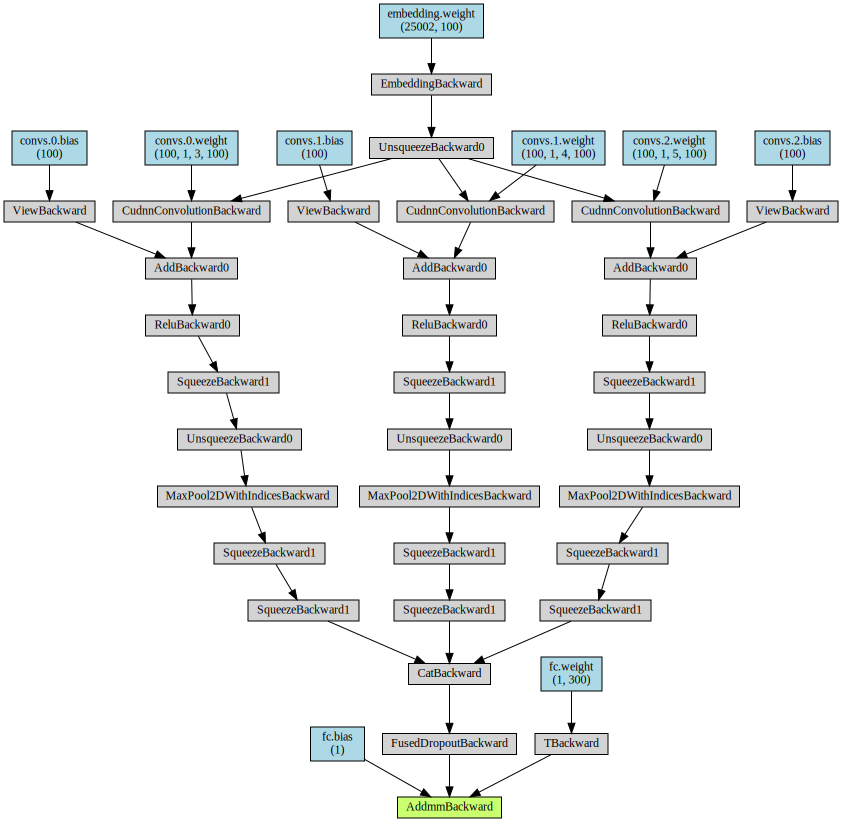

In [ ]:
tmp = next(iter(train_iterator)).text
make_dot(model(tmp), params=dict(model.named_parameters()))

#### Training

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'TextCNN_train.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.640 | Train Acc: 62.36%
	 Val. Loss: 0.477 |  Val. Acc: 79.22%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.416 | Train Acc: 81.01%
	 Val. Loss: 0.348 |  Val. Acc: 85.18%
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.295 | Train Acc: 87.67%
	 Val. Loss: 0.318 |  Val. Acc: 86.68%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.219 | Train Acc: 91.28%
	 Val. Loss: 0.301 |  Val. Acc: 87.42%
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.160 | Train Acc: 94.21%
	 Val. Loss: 0.305 |  Val. Acc: 87.74%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 0.110 | Train Acc: 96.06%
	 Val. Loss: 0.323 |  Val. Acc: 87.44%
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 0.080 | Train Acc: 97.29%
	 Val. Loss: 0.346 |  Val. Acc: 87.72%
Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 0.057 | Train Acc: 98.11%
	 Val. Loss: 0.382 |  Val. Acc: 87.18%
Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 0.044 | Train Acc: 98.52%
	 Val. Loss: 0.403 |  Val. Acc: 87.38%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('TextCNN_train.pt'))

<All keys matched successfully>

#### Testing

We adpoted the best model to run on the test dataset. The TextCNN can have around 86% accuracy rate.

In [5]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.333 | Test Acc: 85.94%


### 3.3 RNN

We use Bi-directional LSTM as our model. Compared with a standard RNN, LSTMs overcome this by having an extra recurrent state called a cell, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple gates which control the flow of information into and out of the memory. 

As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.

![BiLSTM](https://raw.githubusercontent.com/wangys96/6010S-NLP/master/pic/textrnn.png)

#### Definition

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
               n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_idx)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           bidirectional=bidirectional, dropout=dropout)

        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, text):
        # [sent len, batch size, emb dim]
        embedded = self.dropout(self.embedding(text)) 

        # output = [sent len, batch size, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        output, (hidden, cell) = self.rnn(embedded)

        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:])
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
            N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model.embedding.weight.data.copy_(TEXT.vocab.vectors)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)

In [ ]:
print("Network Parameters: ",count_parameters(model))

Network Parameters:  4810857


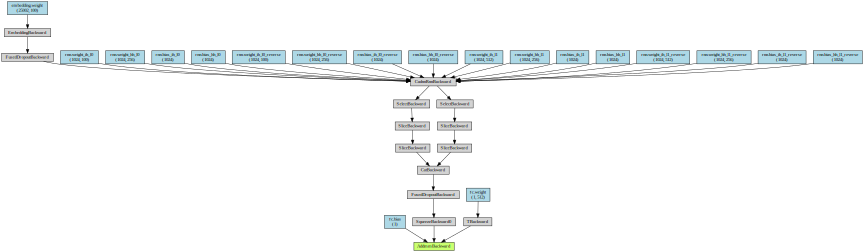

In [ ]:
tmp = next(iter(train_iterator)).text
make_dot(model(tmp), params=dict(model.named_parameters()))

#### Training

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN_train.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.594 | Train Acc: 70.69%
	 Val. Loss: 0.493 |  Val. Acc: 78.31%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.502 | Train Acc: 82.04%
	 Val. Loss: 0.373 |  Val. Acc: 84.53%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.440 | Train Acc: 85.97%
	 Val. Loss: 0.363 |  Val. Acc: 86.17%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.391 | Train Acc: 88.27%
	 Val. Loss: 0.342 |  Val. Acc: 87.73%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.357 | Train Acc: 89.50%
	 Val. Loss: 0.350 |  Val. Acc: 88.20%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.325 | Train Acc: 90.49%
	 Val. Loss: 0.360 |  Val. Acc: 88.60%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.299 | Train Acc: 91.28%
	 Val. Loss: 0.376 |  Val. Acc: 88.88%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.276 | Train Acc: 92.13%
	 Val. Loss: 0.382 |  Val. Acc: 89.25%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.256 | Train Acc: 92.91%
	 Val. Loss: 0.396 |  Val. Acc: 89.45%
Epoch: 10 | Epoch Time: 0m 

#### Testing

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.381 | Test Acc: 86.31%


### 3.4 BERT

The Transformer is a kind of model architecture relying entirely on an attention mechanism to draw global dependencies between input and output. 

![Transformers](https://raw.githubusercontent.com/wangys96/6010S-NLP/master/pic/transformers.png)

The **B**idirectional **E**ncoder **R**epresentations from **T**ransformers, is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications.

![BERT](https://raw.githubusercontent.com/wangys96/6010S-NLP/master/pic/bert.png)

Here we use a pre-trained BERT-base model with a simple GRU and linear layer to perform classification.

In [ ]:
from transformers import BertTokenizer, BertModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Tokenize

BERT has its own vocabulary and trained tokenizer, we import and initialize it.

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
len(tokenizer.vocab)

30522

In [ ]:
cls_token=tokenizer.cls_token
sep_token=tokenizer.sep_token
pad_token=tokenizer.pad_token
unk_token=tokenizer.unk_token
cls_token_id=tokenizer.cls_token_id
sep_token_id=tokenizer.sep_token_id
pad_token_id=tokenizer.pad_token_id
unk_token_id=tokenizer.unk_token_id
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [ ]:
def tokenize_and_cut(sentence):
    return tokenizer.tokenize(sentence)[:max_input_length-2]

In [ ]:
TEXT=data.Field(batch_first=True,use_vocab=False,tokenize=tokenize_and_cut,
                preprocessing=tokenizer.convert_tokens_to_ids,
                init_token=cls_token_id,
                eos_token=sep_token_id,
                pad_token=pad_token_id,
                unk_token=unk_token_id)

LABEL=data.LabelField(dtype=torch.float)

#### Data Preparation

In [ ]:
train_data, test_data =datasets.IMDB.splits(TEXT,LABEL)
train_data,valid_data=train_data.split(split_ratio=0.7)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.36MB/s]


In [ ]:
LABEL.build_vocab(train_data)
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator=data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device)

#### Definition

In [ ]:
from transformers import BertModel
bert=BertModel.from_pretrained('bert-base-uncased')

In [ ]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,bert:BertModel,
                 hidden_dim:int,
                 output_dim:int,
                 n_layers:int,
                 bidirectional:bool,
                 dropout:float):
        super(BERTGRUSentiment, self).__init__()

        self.bert=bert
        embedding_dim=bert.config.to_dict()['hidden_size']

        self.rnn=nn.GRU(embedding_dim,hidden_dim,n_layers,
                        bidirectional=bidirectional,
                        batch_first=True,
                        dropout=0 if n_layers<2 else dropout)

        self.fc=nn.Linear(hidden_dim*2 if bidirectional else hidden_dim,output_dim)

        self.dropout=nn.Dropout(dropout)

    def forward(self,text):
        with torch.no_grad():
            embedding=self.bert(text)[0]
            #embeddiing:(batch,seq,embedding_dim)

        _,hidden=self.rnn(embedding)
        #(bi*num_layers,batch,hidden_size)

        hidden=self.dropout(torch.cat((hidden[-1,:,:],hidden[-2,:,:]),dim=1) if self.rnn.bidirectional else hidden[-1,:,:]) 
        
        return self.fc(hidden)
        #（batch,output_dim）

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
for name, parameters in model.named_parameters():
    if name.startswith('bert'):
        parameters.requires_grad = False

If we freeze the BERT network, only 2.7m parameters are trainable.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


#### Training

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = rounded_preds.eq(y).float() 
    acc = correct.sum() / len(correct)
    return acc

def train(model:nn.Module, iterator:data.BucketIterator, 
          optimizer:optim.Adam, criterion:nn.BCEWithLogitsLoss):
    epoch_loss = 0.
    epoch_acc = 0.
    model.train()
    
    for batch in iterator:
        preds=model(batch.text).squeeze(-1)
        loss=criterion(preds,batch.label)
        acc=binary_accuracy(preds,batch.label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

def evaluate(model: nn.Module, iterator: data.BucketIterator,
           criterion: nn.BCEWithLogitsLoss):
    epoch_loss = 0.
    epoch_acc = 0.
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            preds = model(batch.text).squeeze(-1)
            loss = criterion(preds, batch.label)
            acc = binary_accuracy(preds, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
criterion=nn.BCEWithLogitsLoss()
criterion=criterion.to(device)
model=model.to(device)
optimizer=optim.Adam(model.parameters())

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):    
    start_time = time.time()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)        
    end_time = time.time()        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_train.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 16m 57s
	Train Loss: 0.510 | Train Acc: 73.98%
Epoch: 02 | Epoch Time: 17m 7s
	Train Loss: 0.278 | Train Acc: 88.52%
Epoch: 03 | Epoch Time: 17m 9s
	Train Loss: 0.237 | Train Acc: 90.56%
Epoch: 04 | Epoch Time: 17m 11s
	Train Loss: 0.216 | Train Acc: 91.63%
Epoch: 05 | Epoch Time: 17m 10s
	Train Loss: 0.182 | Train Acc: 93.15%


In [ ]:
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):    
    start_time = time.time()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)        
    end_time = time.time()        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_train1.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 17m 5s
	Train Loss: 0.159 | Train Acc: 93.94%
	 Val. Loss: 0.212 |  Val. Acc: 91.94%
Epoch: 02 | Epoch Time: 17m 6s
	Train Loss: 0.133 | Train Acc: 94.73%
	 Val. Loss: 0.243 |  Val. Acc: 92.29%
Epoch: 03 | Epoch Time: 17m 9s
	Train Loss: 0.104 | Train Acc: 96.12%
	 Val. Loss: 0.267 |  Val. Acc: 91.35%
Epoch: 04 | Epoch Time: 17m 8s
	Train Loss: 0.087 | Train Acc: 96.93%
	 Val. Loss: 0.278 |  Val. Acc: 91.41%
Epoch: 05 | Epoch Time: 17m 9s
	Train Loss: 0.072 | Train Acc: 97.37%
	 Val. Loss: 0.334 |  Val. Acc: 91.61%


#### Testing

In [ ]:
model.load_state_dict(torch.load('BERT_train.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.198 | Test Acc: 92.15%


## Conclusion

Performance on test dataset:

| model |   train accuracy   | train loss  |   test accuracy    |  test loss  |
| :--:  | :----------------: |  :-------:  |  :---------------: |  :--------: |
| CNN   |       94.21%       |    0.160    |        85.94%      |    0.333    | 
| LSTM  |       93.41%       |    0.239    |        86.31%      |    0.381    | 
| BERT  |       97.37%       |    0.072    |        92.15%      |    0.198    | 


The state-of-the-art model BERT outperform other model more then 5% on test set. In other words, the pre-trained encoder can better understand the correlation and sentiment of the sentences. Although it require huge computation power to train even we freeze the BERT net, we believe in the future the transformers model series will continuesly grow larger and perform better.

## References

[\[1\] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.](https://nlp.stanford.edu/pubs/glove.pdf)   
[\[2\] Kim, Y. 2014. Convolutional neural networks for sentence classification.](https://arxiv.org/abs/1408.5882)  
[\[3\] Vaswani,A.,Shazeer,N.,Parmar,N., Uszkoreit,J.,Jones,L.,&Gomez,A.N.,etal. 2017. Attention is all you need.](https://arxiv.org/abs/1706.03762)  
[\[4\] DEVLIN, Jacob, et al. Bert: Pre-training of deep bidirectional transformers for language understanding.](https://arxiv.org/abs/1810.04805)
